## Feature Selection

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
from pathlib import Path
import seaborn as sns
import pandas as pd
import numpy as np
import time
import random
import scipy.io as sio
import warnings

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.pyplot import figure


# sklearn
import sklearn
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_validate


# internal modules
from base_regressor_plot import BaseRegressorPlot
from configurations import args
from data_loader_fs import DataLoaderFS
from elastic_net_regressor import ElasticNetRegressor
from decision_tree_regressor import DecisionTreeRegressor
from lasso_regressor import LassoRegressor
from linear_regressor import LinearRegressor
from random_forest_regressor import RandomForestRegressor
from ridge_regressor import RidgeRegressor
from neuralnetwork import create_nn_regressor


1. Filter method
-  using correlation to identify important features
-  using mutual information (enthropy based)to identify imporatnt features

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
DataLoaderFS.get_top_feature

<function data_loader_fs.DataLoaderFS.get_top_feature(self, top_corr, mi_scores, X_filter_fs)>

1.1 Corrlation based feature selection 


(can be potentially better integrated with the EDA corrlation part)

In [4]:
# download data file if it is not ready
data_file = Path(args.data_path)
if data_file.is_file():
    print("Datafile is already loaded.")
else:
    !curl -L "https://drive.google.com/uc?export=download&id=1ortEJfmlpt9-dbg5f6cTDt5nicswf5wT" > 'test.csv'
    !curl -L "https://drive.google.com/uc?export=download&id=1EG5jP5RDEIsNAMaF2m42KOyz-ZVjC8wS" > 'train.csv'
data_loader = DataLoaderFS(args)
df = data_loader.df

Datafile is already loaded.


In [5]:
# na_list=list(df.select_dtypes(exclude={"object"}).columns[df.select_dtypes(exclude={"object"}).\
#     isna().sum(axis=0)>0])
# df[na_list].sort_values(by=['GarageYrBlt', 'LotFrontage', 'MasVnrArea'])
# df.LotFrontage.isna().sum()
# df.columns[df.columns.str.contains("Vnr")]
# df[['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
#        'GarageQual', 'GarageCond']][df.GarageYrBlt==df.GarageYrBlt].GarageYrBlt.sort_values()
# df[['MasVnrType', 'MasVnrArea']][df.MasVnrArea!=df.MasVnrArea]
# df[df.MasVnrArea!=df.MasVnrArea]

In [6]:
# df_fs = data_loader.df

X_train_fs, X_test_fs, y_train_fs, y_test_fs = data_loader.get_raw_split_fs()
X_filter_fs = data_loader.data_prep(X_train_fs)


In [7]:
regressor_list=[LinearRegression(),
            Ridge(alpha=1.5),
            Lasso(alpha=0.1),
            ElasticNet(alpha=0.1, l1_ratio=0.5),
            DTR(max_depth=10),
            RFR()]

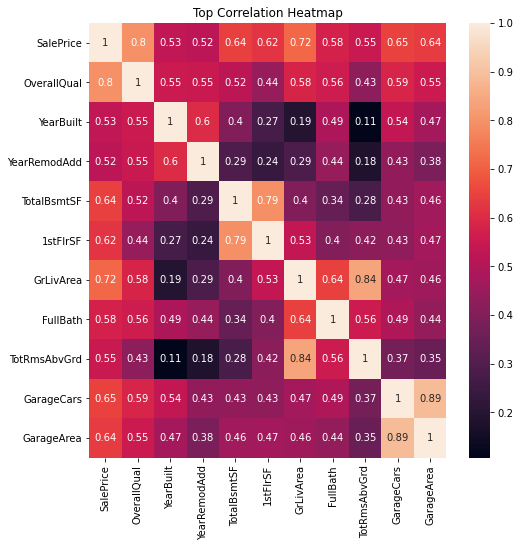

In [8]:
# get only the features with correlation above cutoff

def get_plot_heatmap_top(threshold=0.5):
    
    ''' 
    compute and plot the corr matrix with all top features 
    (correlation with saleprice above above thredshod)
    plot the correlation heatmap
    
    '''
    df_corr = y_train_fs.merge(
        X_train_fs, how="inner", left_index=True, right_index=True)

    corr_matrix = df_corr.corr()
    top_corr = corr_matrix[corr_matrix["SalePrice"] > threshold]
    top_corr = top_corr.loc[:, top_corr.index]

    fig = plt.figure(figsize=(8, 8))
    sns.heatmap(top_corr, annot=True)
    plt.title("Top Correlation Heatmap")

    return top_corr


top_corr = get_plot_heatmap_top()


1.2 Mutual Information based feature selection

In [9]:
#calculate mutual infomation and plot

def make_mi_scores(X, y,threshold=0.15):

    # All discrete features should now have integer dtypes

    mi_scores = mutual_info_regression(X, y,  random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores[mi_scores>threshold]
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    scores = scores
    width = np.arange(len(scores))
    ticks = list(scores.index)
    figure(figsize=(8,6),dpi=100)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


/Users/jq279/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


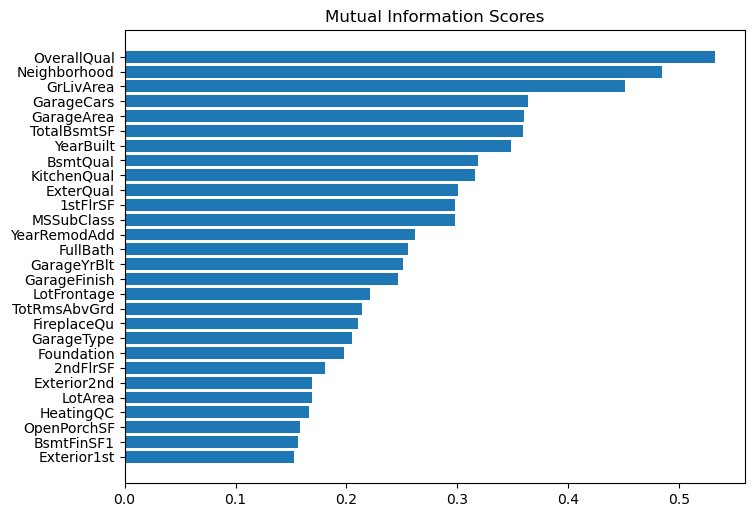

In [10]:
mi_scores = make_mi_scores(X_filter_fs, y_train_fs)
plot_mi_scores(mi_scores)

1.3 Merge to get the final filtered features

In [11]:
features_selected=data_loader.get_top_feature(top_corr, mi_scores, X_filter_fs)
X_train = data_loader.data_prep(X_train_fs[features_selected])
y_train = y_train_fs
X_test = data_loader.data_prep(X_test_fs[features_selected])
y_test = y_test_fs
features_selected


['YearRemodAdd',
 'FullBath',
 'YearBuilt',
 'LotFrontage',
 'BsmtFinSF1',
 'ExterQual',
 'GarageCars',
 'GarageArea',
 'GrLivArea',
 'Foundation',
 'Exterior2nd',
 '2ndFlrSF',
 'GarageType',
 'LotArea',
 'KitchenQual',
 'MSSubClass',
 'OverallQual',
 'Exterior1st',
 'GarageYrBlt',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'Neighborhood',
 'HeatingQC',
 'GarageFinish',
 'BsmtQual',
 'OpenPorchSF',
 'FireplaceQu',
 '1stFlrSF']

1.4 Fit the new feature set to all the models and calculate the metric(RMSE)

In [12]:
regressor_list=[LinearRegression(),
            Ridge(alpha=1.5),
            Lasso(alpha=1,max_iter=3000),
            ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=3000),
            DTR(max_depth=10),
            RFR(max_depth=10)
            ]

In [13]:
def analyze_regression(regressor):
    if regressor.__dict__.get("base_estimator")!=None:
        if str(regressor.__dict__.get("base_estimator"))=="DecisionTreeRegressor()":
            regressor.fit(X_train,np.ravel(np.array(y_train)))
    else: regressor.fit(X_train, y_train)

    # plot dignostics
    #fig, axes = plt.subplots(2, 2, figsize=(10, 5))

    #BaseRegressorPlot.plot_predicted_vs_actual(axes[0,0], regressor)
    #BaseRegressorPlot.plot_learning_curves(axes[0,1], regressor)  
    RMSE=mean_squared_error(y_test, regressor.predict(X_test),squared=False)
    plt.scatter(y_test, regressor.predict(X_test))

    print("For {model} the RMSE is {RMSE}".\
        format(model=regressor,RMSE=RMSE))


For LinearRegression() the RMSE is 28525.95808734997
For Ridge(alpha=1.5) the RMSE is 28505.823210859682
For Lasso(alpha=1, max_iter=3000) the RMSE is 28523.39276914097
For ElasticNet(alpha=0.1, max_iter=3000) the RMSE is 28025.834131501288
For DecisionTreeRegressor(max_depth=10) the RMSE is 39183.594886416606
For RandomForestRegressor(max_depth=10) the RMSE is 29052.824926529283


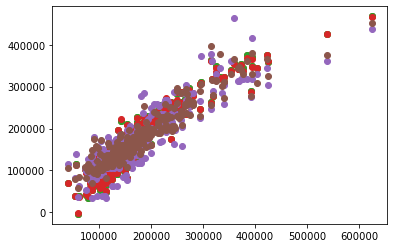

In [14]:
for regressor in regressor_list:

    analyze_regression(regressor)

In [15]:
# check the observed largest prediction errors (need more work)

# regressor = LinearRegressor()
# regressor.fit(X_train, y_train)

# y_predict_test = regressor.predict(X_test)
# df_decile = y_test.reset_index().merge(pd.DataFrame(y_predict_test, columns=["SalePricePredicted"]),
#                                        how="inner", left_index=True, right_index=True).set_index("index")
# # Calculate diff between predicted and actual for test dataset
# df_decile['diff'] = (df_decile.SalePrice-df_decile.SalePricePredicted)
# df_decile['diff_pct'] = (df_decile.SalePricePredicted/df_decile.SalePrice)-1
# df_decile = df_decile.reset_index().merge(X_train, how="inner", left_index=True,
#                                           right_index=True).set_index("index")
# pd.set_option('display.max_rows',
#               df.shape[0]+1), df_decile.sort_values(by='diff_pct').T

2. Wrapper method
recursive feature elemination process to identify features importance

In [32]:
#reset the data to all features
df_fs_w = data_loader.df
X_train_fs_w, X_test_fs_w, y_train_fs_w, y_test_fs_w = data_loader.get_raw_split_fs()


In [41]:
X_train = data_loader.data_prep(X_train_fs_w)
y_train = y_train_fs_w
X_test = data_loader.data_prep(X_test_fs_w)
y_test = y_test_fs_w


In [42]:

def rfe_fs(regressor, threshold=35):
    ''' Select the most important * features based on the model
         and use it as X_train & X_test'''
    selector = RFE(regressor, n_features_to_select=threshold, step=1)
    selector = selector.fit(X_train, y_train)
    selector_ind = selector.get_support()
    X_train_rfe = X_train.iloc[:, selector_ind]
    X_test_rfe = X_test.iloc[:, selector_ind]

    return X_train_rfe, X_test_rfe


In [43]:
def analyze_regression(regressor):

    X_train_rfe, X_test_rfe = rfe_fs(regressor)
    if regressor.__dict__.get("base_estimator")!=None:
        if str(regressor.__dict__.get("base_estimator"))=="DecisionTreeRegressor()":
            regressor.fit(X_train,np.ravel(np.array(y_train)))
    regressor.fit(X_train_rfe, y_train)


    # plot dignostics
    #fig, axes = plt.subplots(2, 2, figsize=(10, 5))

    #BaseRegressorPlot.plot_predicted_vs_actual(axes[0,0], regressor)
    #BaseRegressorPlot.plot_learning_curves(axes[0,1], regressor)
    print(X_train_rfe.columns)
    RMSE=mean_squared_error(y_test, regressor.predict(X_test_rfe),squared=False)
    plt.scatter(y_test, regressor.predict(X_test_rfe))

    print("For {model} the RMSE is {RMSE}".\
    format(model=regressor,RMSE=RMSE))

In [44]:
regressor_list_2=[LinearRegression(),
            Ridge(alpha=1.5),
            Lasso(alpha=1,max_iter=5000),
            ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=5000),
            DTR(max_depth=10),
            RFR(max_depth=10)
            ]

Index(['MSZoning', 'Street', 'Utilities', 'LotConfig', 'LandSlope',
       'Condition1', 'BldgType', 'OverallQual', 'OverallCond', 'RoofStyle',
       'RoofMatl', 'Foundation', 'BsmtQual', 'BsmtExposure', 'HeatingQC',
       'CentralAir', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageCars', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'SaleType',
       'SaleCondition'],
      dtype='object')
For LinearRegression() the RMSE is 37979.672020951955
Index(['MSZoning', 'Street', 'Utilities', 'LotConfig', 'LandSlope',
       'Condition1', 'BldgType', 'OverallQual', 'OverallCond', 'RoofStyle',
       'RoofMatl', 'MasVnrType', 'Foundation', 'BsmtQual', 'BsmtExposure',
       'HeatingQC', 'CentralAir', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Fun

/Users/jq279/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.417e+11, tolerance: 6.622e+08
  model = cd_fast.enet_coordinate_descent(
/Users/jq279/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.501e+11, tolerance: 6.622e+08
  model = cd_fast.enet_coordinate_descent(
/Users/jq279/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consi

Index(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Condition1', 'BldgType', 'OverallQual', 'OverallCond', 'RoofStyle',
       'RoofMatl', 'MasVnrType', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
       'CentralAir', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenQual', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageCars',
       'GarageQual', 'GarageCond', 'PavedDrive', 'Fence', 'SaleType',
       'SaleCondition'],
      dtype='object')
For ElasticNet(alpha=0.1, max_iter=5000) the RMSE is 38671.15092596068
Index(['MSZoning', 'LotFrontage', 'LotArea', 'Neighborhood', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'Foundation', 'BsmtQual', 'BsmtExposure',
       'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'CentralAir', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenQual',

/Users/jq279/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/jq279/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/jq279/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/jq279/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/sklearn/feature

KeyboardInterrupt: 

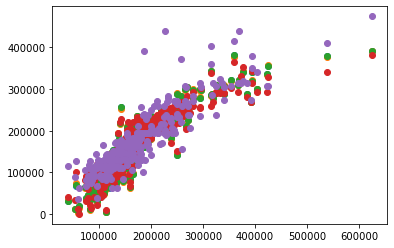

In [45]:
for regressor in regressor_list_2:

    analyze_regression(regressor)